 # Tiltmeter - Correction for Temperature Rate

### Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__readYaml import __readYaml

from scipy import signal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

### Methods

In [2]:
def __conversion(st, confBT, confPT):

    def convertTemp(trace, gain):
        Tvolt = trace.data * gain
        return 10.18 - 11.59*Tvolt + 0.3335*Tvolt**2 - 0.5316*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity
        # print( type(conversion), type(sensitivity), type(trace.data) )

    for tr in st:
        if tr.stats.channel == 'MAT':
            tr.data = convertTemp(tr, confPT['gainTemp'])
        elif tr.stats.channel == 'MAN':
            tr.data = convertTilt(tr, confPT['convPTN'], confPT['gainTilt'])
        elif tr.stats.channel == 'MAE':
            tr.data = convertTilt(tr, confPT['convPTE'], confPT['gainTilt'])

        elif tr.stats.channel == 'LAT':
            tr.data = convertTemp(tr, confBT['gainTemp'])
        elif tr.stats.channel == 'LAN':
            tr.data = convertTilt(tr, confBT['convBTN'], confBT['gainTilt'])
        elif tr.stats.channel == 'LAE':
            tr.data = convertTilt(tr, confBT['convBTE'], confBT['gainTilt'])

    print("  -> converted data")
    return st

In [3]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    for i in range(3):
        
        axes[i,0].plot(pt[i].times()/60, pt[i].data)
        axes[i,1].plot(bt[i].times()/60, bt[i].data)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
    axes[0,0].set_title('Platform Tiltmeter')
    axes[0,1].set_title('Borehole Tiltmeter')
    
    axes[2,0].set_xlabel("Time (min)")
    axes[2,1].set_xlabel("Time (min)")
    
    axes[0,0].set_ylabel("$\Omega$ (rad)")
    axes[1,0].set_ylabel("$\Omega$ (rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,1].set_ylabel("$\Omega$ (rad)")
    axes[1,1].set_ylabel("$\Omega$ (rad)")
    axes[2,1].set_ylabel("Temp (°C)")
    
    return fig 

In [4]:
def __removeLinearTrend(data):

    for i in range(2):
        N = data[i].stats.npts
        m = (data[i].data[-1] - data[i].data[0]) / (data[i].stats.delta * N)
        data[i].data = data[i].data - np.arange(0, N) * m
    return data

In [5]:
def __smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

### Configurations

In [6]:
## Paramter Settings
config ={
         'seed_id': ["BW.TROMY..MA*", "BW.DROMY..LA*"],
         'repos': 'george',
         'datapath': None,
         'name': 'test',
         'set_filter': 'n'
        }

## choose tiltmeter
# config['tiltmeter'] = 'bt'
config['tiltmeter'] = 'pt'

config['smoothing'] = 100

config['cc_shift'] = True

In [7]:

## pt linear & bt not-linear
# config['tbeg'] = "2021-07-21T06:20:00.000000Z"
# config['tend'] = "2021-07-21T06:30:00.000000Z"

## pt linear & bt linear -> hardly any temperature change
# config['tbeg'] = "2021-08-25T00:00:00.000000Z"
# config['tend'] = "2021-08-25T00:30:00.000000Z"

# config['tbeg'] = "2021-08-25T00:00:00.000000Z"
# config['tend'] = "2021-08-25T00:22:00.000000Z"

## longer selection 
# config['tbeg'] = "2021-07-21T06:30:00.000000Z"
# config['tend'] = "2021-07-21T22:00:00.000000Z"

## disturbed signal BT && 'parabel' for PT
# config['tbeg'] = "2021-11-03T06:00:00.000000Z"
# config['tend'] = "2021-11-03T12:00:00.000000Z"

## short corrections on hourly basis... moving correction?!
config['tbeg'] = "2021-07-21T06:30:00.000000Z"
config['tend'] = "2021-07-21T07:30:00.000000Z"


In [8]:
## tiltmeter configuration
try:
    confTilt = __readYaml('/home/brotzer/Documents/ROMY/','tiltmeter.conf')
except:
    confTilt = __readYaml('./','tiltmeter.conf')
    
confPT = confTilt['PT']
confBT = confTilt['BT']

### Load Tilt Data

load data for the platform tiltmeter

In [9]:
pt, inv0 = __querrySeismoData(    
                            seed_id=config.get("seed_id")[0],
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            where=config.get("repos"),
                            path=config.get("datapath"),
                            restitute=True,
                            detail=None,
                            )
# pt.resample(1.0) 

pt

Coordinates could not be attached! Inventory not complete!


3 Trace(s) in Stream:
BW.TROMY..MAE | 2021-09-20T00:00:00.040000Z - 2021-09-24T00:00:00.040000Z | 5.0 Hz, 1728001 samples
BW.TROMY..MAN | 2021-09-20T00:00:00.039999Z - 2021-09-24T00:00:00.039999Z | 5.0 Hz, 1728001 samples
BW.TROMY..MAT | 2021-09-20T00:00:00.039999Z - 2021-09-24T00:00:00.039999Z | 5.0 Hz, 1728001 samples

load data for borehole tiltmeter

In [10]:
bt, inv0 = __querrySeismoData(    
                            seed_id=config.get("seed_id")[1],
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            where=config.get("repos"),
                            path=config.get("datapath"),
                            restitute=True,
                            detail=None,
                            )
bt

Coordinates could not be attached! Inventory not complete!


3 Trace(s) in Stream:
BW.DROMY..LAE | 2021-09-20T00:00:00.000000Z - 2021-09-24T00:00:00.000000Z | 1.0 Hz, 345601 samples
BW.DROMY..LAN | 2021-09-20T00:00:00.000000Z - 2021-09-24T00:00:00.000000Z | 1.0 Hz, 345601 samples
BW.DROMY..LAT | 2021-09-20T00:00:00.000000Z - 2021-09-24T00:00:00.000000Z | 1.0 Hz, 345601 samples

Convert data using the specifications of the tiltmeters

In [11]:
pt = __conversion(pt, confBT, confPT)

bt = __conversion(bt, confBT, confPT)

  -> converted data
  -> converted data


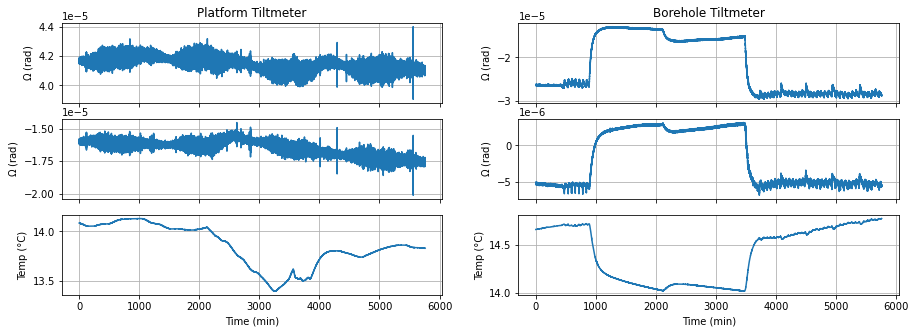

In [12]:
fig = __makeplot(pt, bt, config);

## Correction for LongTerm Temperature Trend

In [13]:
correction_LT_pt = __readYaml("./", "correction_longterm_pt.yml")
correction_LT_bt = __readYaml("./", "correction_longterm_bt.yml")

## correct with regression slope and temperature
pt[0].data = pt[0].data - float(correction_LT_pt.get('slopes').get('C1')) * pt[2].data
pt[1].data = pt[1].data - float(correction_LT_pt.get('slopes').get('C2')) * pt[2].data

## correct with regression slope and temperature
bt[0].data = bt[0].data - float(correction_LT_bt.get('slopes').get('C1')) * bt[2].data
bt[1].data = bt[1].data - float(correction_LT_bt.get('slopes').get('C2')) * bt[2].data

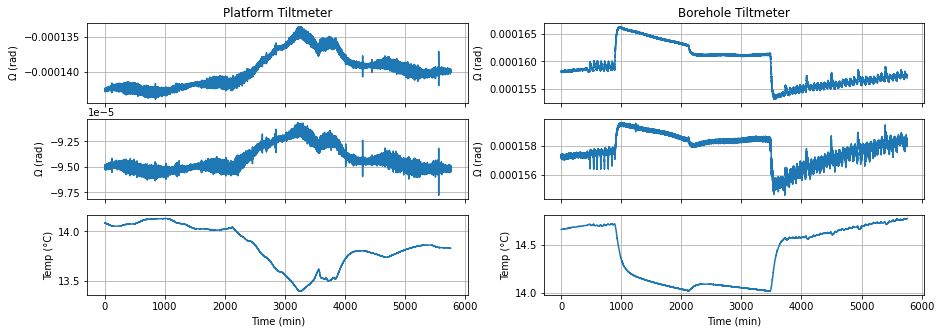

In [14]:
fig = __makeplot(pt, bt, config);

## CrossCorrelation

In [15]:
def __cross_correlation(y1, y2, norm=False, plot=True):
    """Calculates the cross correlation and lags.

    Args:
        y1, y2: Should have the same length.
        norm:   Boolean (False | True) for normalization 
    Returns:
        max_corr: Maximum correlation without normalization.
        lag: The lag in terms of the index.
    """
    
    from scipy.signal import correlate
    
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    ## calulate autocorrelation
    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    
    ## normalize input traces ?!
#     y1 /= np.max(abs(y1))
#     y2 /= np.max(abs(y2))
    
    ## calculate crorrelation function
    corr = correlate(y1, y2, mode='same')
    
    # The unbiased sample size is N - lag.
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')

    ## 
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    
    ## normalize
    if norm:
        corr /= np.max(abs(corr))
        
    ## calculate lag times 
    xlags = np.arange(-corr.size//2, corr.size//2, 1)

    ## get maximum    
#     corr_max_y = np.max(abs(corr))
    corr_max_x = np.argmax(abs(corr))-corr.size//2
    corr_max_y = corr[int(corr_max_x + corr.size//2)]
    
    
    shifted = np.roll(y2*corr_max_y, corr_max_x)

    
    ## Plotting
    if plot == True:
        fig, ax = plt.subplots(3, 1, figsize=(15,8))

        ax[0].plot(y1)

        ax[1].plot(y2)
        ax[1].plot(shifted)

        ax[2].plot(xlags, corr)

        ax[2].scatter(corr_max_x, corr_max_y, color='orange', zorder=3)
        ax[2].axvline(corr_max_x, color='k', ls=":")
        ax[2].axhline(corr_max_y, color='k', ls=":")

        for i in range(3):
            ax[i].grid(ls=":", zorder=1)
            
        plt.show();

    return corr, xlags, (corr_max_x, corr_max_y)

Creating data frames and removing linear/constant trend 

In [16]:
df_bt = pd.DataFrame({'c1':bt[0].data, 
                    'c2':bt[1].data, 
                    't': bt[2].data
                   })
df_pt = pd.DataFrame({
                   'c1': pt[0].data,
                   'c2': pt[1].data,
                   't':  pt[2].data
                    })

## linear detrend
detrend_type = 'constant' 
df_bt.c1 = signal.detrend(df_bt.c1.values, type=detrend_type)
df_bt.c2 = signal.detrend(df_bt.c2.values, type=detrend_type)
df_bt.t  = signal.detrend(df_bt.t.values, type=detrend_type)

df_pt.c1 = signal.detrend(df_pt.c1.values, type=detrend_type)
df_pt.c2 = signal.detrend(df_pt.c2.values, type=detrend_type)
df_pt.t  = signal.detrend(df_pt.t.values, type=detrend_type)

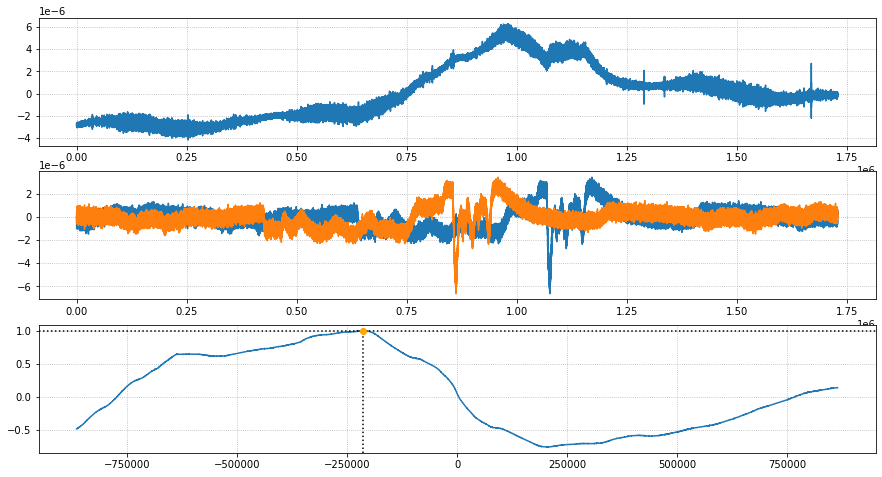

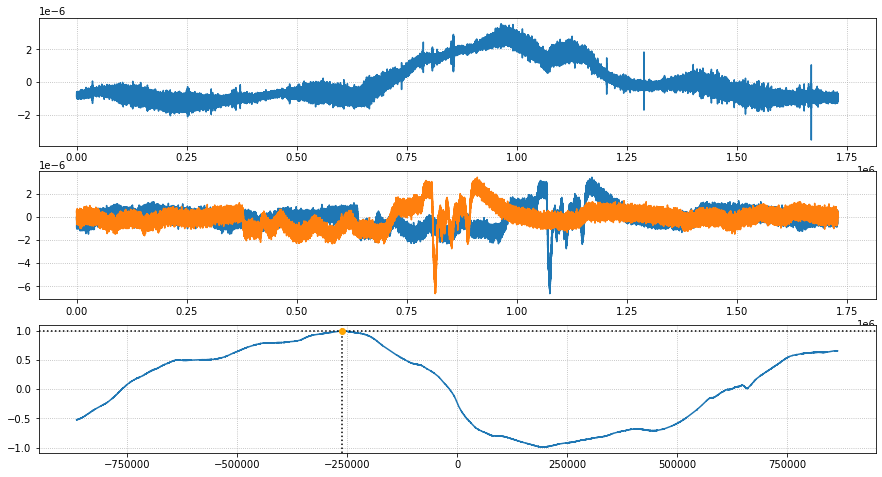

Maximum Correltation for C1 at: 
 x: -213045 
 y: 1.0
Maximum Correltation for C2 at: 
 x: -260284 
 y: 1.0


In [17]:
## select component and tiltmeter
if config['tiltmeter'] == 'pt':
    s0 = df_pt.c1
    s1 = df_pt.c2
    s2 = df_pt.t
elif config['tiltmeter'] == 'bt':
    s0 = df_bt.c1
    s1 = df_bt.c2
    s2 = df_bt.t

## compute the derivative
s2 = np.gradient(s2, 2)

## smooth the derivative
s2 = __smooth(s2, config['smoothing'])

## compute cross-correlation
cc0, cc_lags0, cc_max0 = __cross_correlation(s0, s2 , norm=True)
cc1, cc_lags1, cc_max1 = __cross_correlation(s1, s2 , norm=True)

cc = [cc0, cc1]
cc_lags = [cc_lags0, cc_lags1]
cc_max = [cc_max0, cc_max1]

print(f"Maximum Correltation for C1 at: \n x: {cc_max[0][0]} \n y: {cc_max[0][1]}")
print(f"Maximum Correltation for C2 at: \n x: {cc_max[1][0]} \n y: {cc_max[1][1]}")

## Correction with slope value

In [18]:

# pt_corr = pt.copy()
# bt_corr = bt.copy()

# factors = [-0.9e-6, -0.9e-6] ## degrees / rad

# pt_corr[0].data = pt[0].data + factors[0] * pt[2].data
# pt_corr[1].data = pt[1].data + factors[1] * pt[2].data

# bt_corr[0].data = bt[0].data + factors[0] * bt[2].data
# bt_corr[1].data = bt[1].data + factors[1] * bt[2].data

# fig = __makeplot(pt_corr, bt_corr, config);

## Linear Regression

In [19]:
def __estimate_linear_trend(st, derive=None, smooth=None):
    
    temp = st[2].data
    
    if derive:
        temp = np.gradient(temp, 2)
        
    if smooth:
        temp = __smooth(temp, smooth)

    ## compute linear regression of data
    out1 = scipy.stats.linregress(temp, st[0].data)
    out2 = scipy.stats.linregress(temp, st[1].data)
    
    ## prepare output dictionary
    output = {}
    output['slope'] = [out1.slope, out2.slope]
    output['intercept'] = [out1.intercept, out2.intercept]
    
    return output

In [20]:
def __makeplot_compare(st, slopes, intercepts, derive=None, poly=None, smooth=None, coeff=None):
    
    if derive:
        x_temp = np.gradient(st[2].data, 2)
    else:
        x_temp = st[2].data     
        
        
    if smooth:
        x_temp = __smooth(x_temp, smooth)

    
    fig, ax = plt.subplots(3, 2, figsize=(15,10))

    plt.subplots_adjust(hspace=0.3)
    
    ax[0][0].plot(st[0].times()/60, st[2].data, label="Temp")
    axes1 = ax[0][0].twinx()
    axes1.plot(st[0].times()/60, x_temp, 'g', label="dT/dt")
    
    ax[0][1].plot(st[0].times()/60, st[2].data, label="Temp")
    axes2 = ax[0][1].twinx()
    axes2.plot(st[0].times()/60, x_temp, 'g', label="dT/dt")
    
    for i in range(2):
        ax[1][i].plot(x_temp, st[i].data, 'k.', ms=0.2)

        if not poly:        
            ax[1][i].plot(x_temp, slopes[i]*x_temp + intercepts[i], 'r')
            
            correction = slopes[i] * x_temp

            ax[2][i].plot(st[i].times()/60, st[i].data - correction, label="corrected")
            ax[2][i].plot(st[i].times()/60, st[i].data, color='grey', alpha=0.5, label="observed")

        else: 
            ax[1][i].plot(x_temp, ffit[i], 'r')
            ax[2][i].plot(st[i].times()/60, st[i].data - poly[i], label="corrected")
            ax[2][i].plot(st[i].times()/60, st[i].data - coeff[i][0], color='grey', alpha=0.5, label="observed")
            
    ax[0][0].set_title("Component 1")
    ax[0][1].set_title("Component 2")

    ax[1][0].set_xlabel("Derivative of Temperature (°C)")
    ax[1][1].set_xlabel("Derivative of Temperature (°C)")
    
    ax[0][0].set_xlabel("Time (min)")
    ax[0][1].set_xlabel("Time (min)")
    
    ax[2][0].set_xlabel("Time (min)")
    ax[2][1].set_xlabel("Time (min)")
    
    ax[0][0].set_ylabel("Temperature (°C)")
    axes2.set_ylabel("dT/dt ")
    ax[1][0].set_ylabel("Tilt (rad)")
    ax[2][0].set_ylabel("Tilt (rad)")

    
    ax[0][1].legend(loc="upper left")
    ax[0][0].legend(loc="lower right")
    axes1.legend(loc="upper left")
    axes2.legend(loc="lower right")

    ax[2][0].legend()
    
    plt.plot();
    return fig

slopes: [1.1264301346364025, 0.49229031769535658] 
intercepts: [-0.00013968199656838549, -9.4199818287550685e-05]


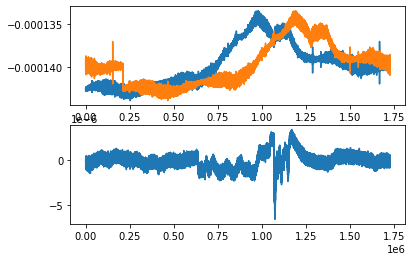

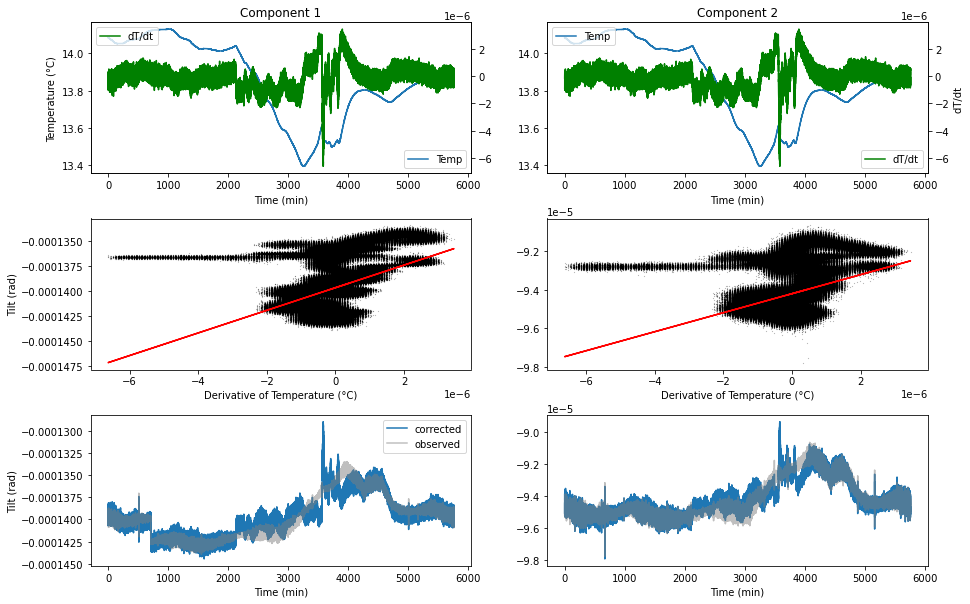

In [21]:
if config['tiltmeter'] == 'pt':
    st = pt.copy()
elif config['tiltmeter'] == 'bt':
    st = bt.copy()
    

## apply crosscorrelation lag
if config['cc_shift']:
    st[0].data = np.roll(st[0].data, -cc_max[0][0])
    st[1].data = np.roll(st[1].data, -cc_max[1][0])


## compute linear regression 
out = __estimate_linear_trend(st, derive=True, smooth= config['smoothing'])

print(f"slopes: {out.get('slope')} \nintercepts: {out.get('intercept')}")


__makeplot_compare(st, out.get('slope'), out.get('intercept'), derive=True, smooth= config['smoothing']);

## Orthogonal Distance Regression

In [22]:
def __get_odr_estimate(st, std=[1, 1], derive=None, smooth=None):

    from scipy import odr

    def f(B, x):
        '''Linear function y = m*x + b'''
        return B[0]*x + B[1]
    
    output = {}
    output['slope'] = []
    output['intercept'] = []
    
    for i in range(2):
        
        y = st[i].data
        x = st[2].data

        if derive: 
            x = np.gradient(x, 2)
        
        if smooth:
            x = __smooth(x, smooth)
        
        sx = std[0]
        sy = std[1]

        linear = odr.Model(f)

        mydata = odr.Data(x, y, wd=1./np.power(sx,2), we=1./np.power(sy,2))

        # mydata = RealData(x, y, sx=sx, sy=sy)

        myodr = odr.ODR(mydata, linear, beta0=[1., 1.])

        myoutput = myodr.run()
        
        output['slope'].append(myoutput.beta[0])
        output['intercept'].append(myoutput.beta[1])
        
    return output

CC-max: [(-213045, 1.0), (-260284, 1.0)]
slopes: [1.1264301311703075, 0.49229032758152985] 
intercepts: [-0.00013968199657000537, -9.4199818286825219e-05]


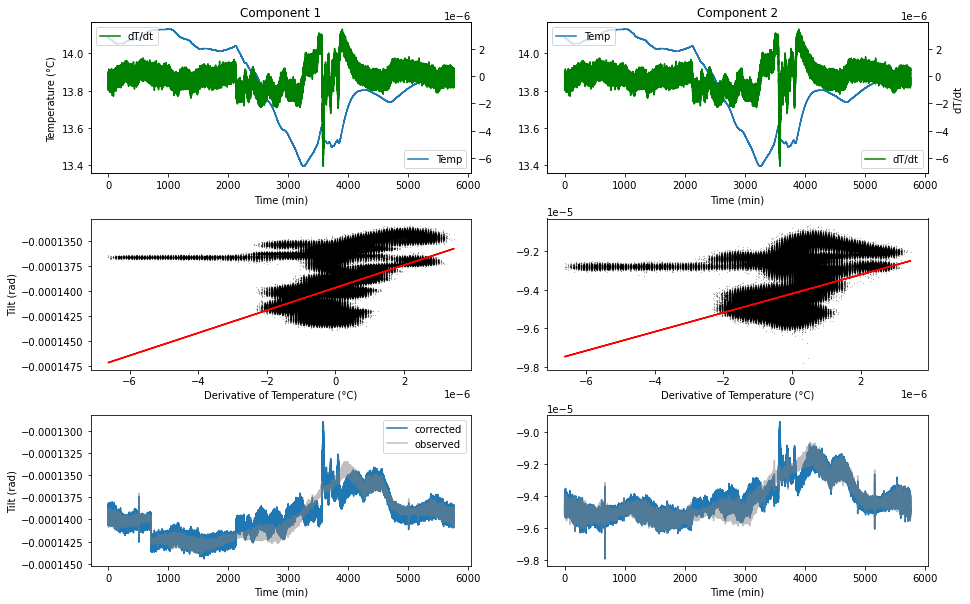

In [23]:
if config['tiltmeter'] == 'pt':
    st = pt.copy()
elif config['tiltmeter'] == 'bt':
    st = bt.copy()

## apply crosscorrelation lag
if config['cc_shift']:
    st[0].data = np.roll(st[0].data, -cc_max[0][0])
    st[1].data = np.roll(st[1].data, -cc_max[1][0])
    print(f"CC-max: {cc_max}")

## compute linear regression 
out = __get_odr_estimate(st, std=[5e-6, 0.5], derive=True, smooth= config['smoothing'])

print(f"slopes: {out.get('slope')} \nintercepts: {out.get('intercept')}")

__makeplot_compare(st, out.get('slope'), out.get('intercept'), derive=True, smooth= config['smoothing']);

## Fit Data with Polynomial Function

[ -1.40020821e-04   1.66645351e+00   6.93370038e+05  -1.39316054e+11
  -3.35278994e+16]
[ -9.43686411e-05   7.19230044e-01   3.37937454e+05  -5.99097640e+10
  -1.55725947e+16]


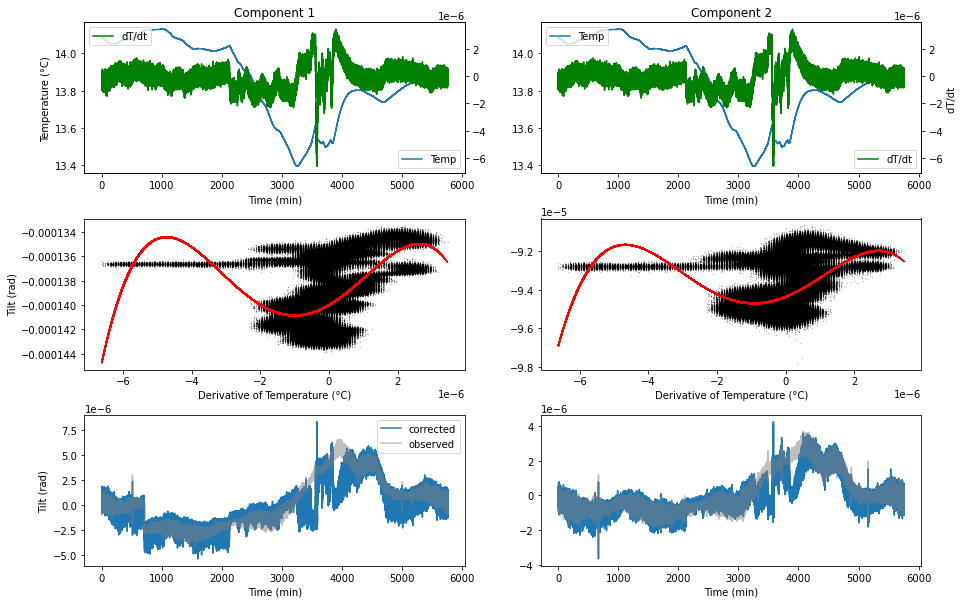

In [24]:
import numpy.polynomial.polynomial as poly

if config['tiltmeter'] == 'pt':
    st = pt.copy()
elif config['tiltmeter'] == 'bt':
    st = bt.copy()

## apply crosscorrelation lag
if config['cc_shift']:
    st[0].data = np.roll(st[0].data, -cc_max[0][0])
    st[1].data = np.roll(st[1].data, -cc_max[1][0])


## select data
coefs = [[], []]
ffit  = [[], []]
for i in range(2):

    data = st[i].data
    
    ## compute gradient of temperature
    temp = np.gradient(st[2].data, 2)

    ## smoothing gradient
    temp = __smooth(temp,  config['smoothing'])
        
    ## get poly coefficients
    coefs[i] = poly.polyfit(temp, data, 4)
    print(coefs[i])
 
    ## calulate poly function
    ffit[i] = poly.polyval(temp, coefs[i])

    
__makeplot_compare(st, None, None, derive=True, smooth= config['smoothing'], poly=ffit, coeff=coefs);
